# Overview
* **Load experimental IRFs** acquired from various sources (please refer to the README for details)
* **Compress** the dimensions to 256 points to align with in-house IRFs, if required
* **Normalise** the IRFs so that values range between 0 and 1

Although publicly available IRFs may have been captured with varying time resolutions or bin counts, our primary focus here is on the differences in width and shape of the experimental IRFs

## Load experimental IRFs

In [1]:
import os
import numpy as np
import h5py
import scipy.io as sio 
import matplotlib.pyplot as plt
from scipy.stats import skewnorm, norm

from utils_simulation import load_sdt, normalise_irf, resample_array

In [2]:
irf_dir = 'data/irfs'

In [3]:
# load and normalise in-house IRFs aquired using 2 different detectors (PMT and APD)
IRF_PMT, PMT_tseries = load_sdt(irf_dir, 'IRF_inhouse_PMT.sdt')
IRF_PMT = normalise_irf(IRF_PMT)

IRF_APD = normalise_irf(np.loadtxt(os.path.join(irf_dir, 'IRF_inhouse_APD.csv'), delimiter=','))
IRF_APD = normalise_irf(IRF_APD)

# load publically available IRFs
with h5py.File(os.path.join(irf_dir, 'IRF_FPFLI.mat'), 'r') as f:
    IRF_FPFLI = normalise_irf(f['irf'][:, 0])
# load only first IRF contained in IRF_DL4FLI.mat file
IRF_DL4FLI = normalise_irf(sio.loadmat(os.path.join(irf_dir ,'IRF_DL4FLI.mat'))['irf_whole'][:, 0])
IRF_DLT = np.loadtxt(os.path.join(irf_dir,'IRF_DLT.dat'))[:, 1]
# compress IRF_DLT dimentions to 256
IRF_DLT = normalise_irf(resample_array(IRF_DLT, 256))
IRF_flimfit = normalise_irf(np.loadtxt(os.path.join(irf_dir,'IRF_flimfit_py.txt')))

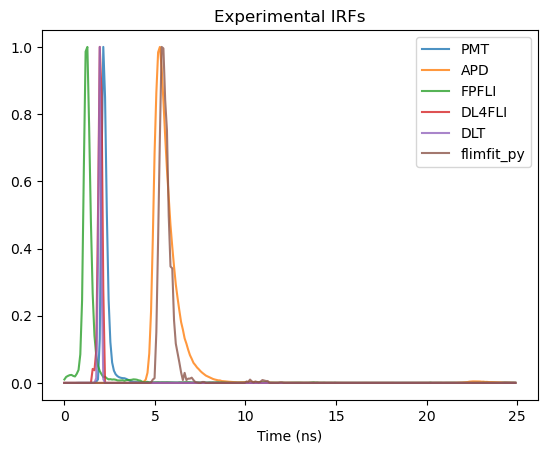

In [4]:
# plot expetimental IRFs
plt.plot(PMT_tseries, IRF_PMT, label = 'PMT', alpha=0.8)
plt.plot(PMT_tseries, IRF_APD, label = 'APD', alpha=0.8)
plt.plot(PMT_tseries, IRF_FPFLI, label = 'FPFLI', alpha=0.8)
plt.plot(PMT_tseries, IRF_DL4FLI, label = 'DL4FLI', alpha=0.8)
plt.plot(PMT_tseries, IRF_DLT, label = 'DLT', alpha=0.8)
plt.plot(PMT_tseries, IRF_flimfit, label = 'flimfit_py', alpha=0.8)

plt.xlabel("Time (ns)")
plt.title("Experimental IRFs")

plt.legend()
plt.show()

## Data simulation process

**Simulation of synthetic IRFs to closely match our in-house PMT IRF, featuring**:

* **Gaussian**-like decay curve
* Slight **right skew**, accunting for IRF asymmetry due to detector delays
* Optional **secondary peak**, often present due to experimental artefacts, such as afterpulsing

In [5]:
def simulate_IRF(bin_number = 256, bin_width = 0.0977,  sigma = 0.30, loc = 2, 
                 skewness = 8, sigma_s=0.3,  loc_secondary = 3.2, secondary_peak_ratio = 0.03):
    """
    Parameters:
    - bin_number: number of time bins for the IRF
    - bin_width: width of each time bin in ns
    - sigma: standard deviation of the primary IRF peak
    - loc: center of the primary IRF peak in ns
    - skewness: Skewness  for the primary IRF peak
    - sigma_s: standard deviation of the secondary IRF peak
    - loc_secondary: center of the secondary peak in ns
    - secondary_peak_ratio: amplitude of the secondary peak relative to the primary IRF peak, if zero the secondary peak wont be simulated 
    Please note that the parameters have been optimised to match our in-house PMT IRF
    """
                 
    ## simuate time axis from the bin width and number of bins
    t_axis = np.asarray([i * bin_width for i in range(bin_number)], dtype =np.float32)
    # Given parameters

    # Generate primary IRF
    primary_irf = skewnorm.pdf(t_axis, skewness, loc=loc, scale=sigma)

    # if ratio between primary and secondary peak (secondary_peak_ratio) is set to zero, seondary peak wont be simulated
    secondary_peak_ratio = secondary_peak_ratio * norm.pdf(t_axis, loc=loc_secondary, scale=sigma)
    
    # Combine the primary and secondary IRFs
    irf = primary_irf + secondary_peak_ratio
    
    # Normalsze the combined IRF so the maximum equals 1
    irf /= np.max(irf)

    return irf, t_axis

### Simulating IRFs

In [6]:
# Simulating IRFs that closely match in-house PMT IRF
IRF_simulated_s, _ = simulate_IRF(bin_number = 256, bin_width = 0.0977,  sigma = 0.3, loc = 2, 
                 skewness =4, loc_secondary = 3.2, secondary_peak_ratio = 0.025)

# secondary_peak_ratio set to zero to remove the secondary peak
IRF_simulated, _ = simulate_IRF(bin_number = 256, bin_width = 0.0977,  sigma = 0.3, loc = 2, 
                 skewness =4, sigma_s=0.3, loc_secondary = 3.2, secondary_peak_ratio = 0.0)

In [7]:
# simulating IRFs with broader FHWM than the in-house PMT IRF  
IRF_simulated_broad_s, _ = simulate_IRF(bin_number = 256, bin_width = 0.0977,  sigma = 0.3*2, loc = 2, 
                 skewness =4, sigma_s= 0.5 ,  loc_secondary = 4.1, secondary_peak_ratio = 0.05)

# secondary_peak_ratio set to zero to remove the secondary peak
IRF_simulated_broad, _ = simulate_IRF(bin_number = 256, bin_width = 0.0977,  sigma = 0.3*2, loc = 2, 
                 skewness =4, sigma_s= 0.5 ,  loc_secondary = 4.1, secondary_peak_ratio = 0.0)

In [8]:
# simulating IRFs with narrower FHWM than the in-house PMT IRF  
IRF_simulated_narrow_s, _ = simulate_IRF(bin_number = 256, bin_width = 0.0977,  sigma = 0.3*0.5, loc = 2, 
                 skewness =3, sigma_s= 0.2,  loc_secondary = 2.7, secondary_peak_ratio = 0.025)

# secondary_peak_ratio set to zero to remove the secondary peak
IRF_simulated_narrow, _ = simulate_IRF(bin_number = 256, bin_width = 0.0977,  sigma = 0.3*0.5, loc = 2, 
                 skewness =3, sigma_s= 0.2,  loc_secondary = 2.7, secondary_peak_ratio = 0.0)

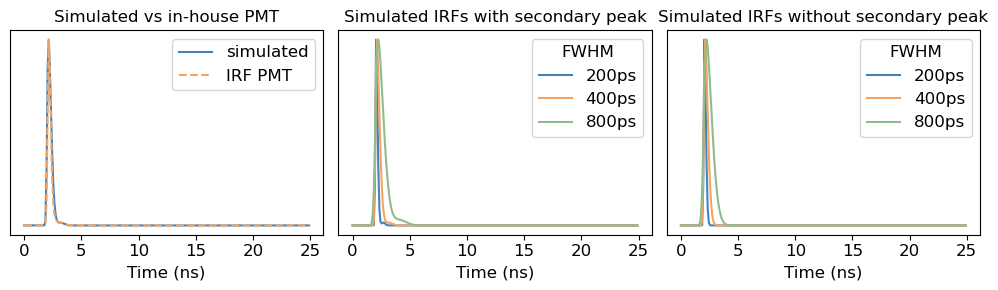

In [9]:
# Create a figure with 3 subplots (side by side)
fig, axes = plt.subplots(1, 3, figsize=(10, 3))  # 1 row, 3 columns
title_font = 12
text_font = 12

# First plot: Simulated IRF vs IRF_PMT
axes[0].plot(PMT_tseries, IRF_simulated_s, label='simulated', color = "steelblue")
axes[0].plot(PMT_tseries, IRF_PMT, label='IRF PMT', alpha=1, linestyle='--', color = "sandybrown")
axes[0].legend(fontsize=10)  # Increase legend font size
axes[0].set_title("Simulated vs in-house PMT", fontsize=title_font)  # Increase title font size
axes[0].set_xlabel("Time (ns)", fontsize=text_font)  # Increase x-axis label font size
axes[0].tick_params(axis='both', which='major', labelsize=text_font)  # Increase tick size
axes[0].legend(fontsize=text_font)
axes[0].set_yticks([])  

# Second plot: (Example for the second figure, replace with your data)
axes[1].plot(PMT_tseries, IRF_simulated_narrow_s, label='200ps', alpha=1, color = "steelblue")
axes[1].plot(PMT_tseries, IRF_simulated_s, label='400ps', alpha=1, color = "sandybrown")
axes[1].plot(PMT_tseries, IRF_simulated_broad_s, label='800ps', alpha=1, color = "darkseagreen")
axes[1].set_title("Simulated IRFs with secondary peak", fontsize=title_font)
axes[1].set_xlabel("Time (ns)", fontsize=text_font)
axes[1].legend(fontsize=text_font, title="FWHM", title_fontsize=text_font)
axes[1].set_yticks([])  # Remove y-ticks
axes[1].tick_params(axis='both', which='major', labelsize=text_font)

# Third plot: (Example for the third figure, replace with your data)
axes[2].plot(PMT_tseries, IRF_simulated_narrow, label='200ps', color = "steelblue")
axes[2].plot(PMT_tseries, IRF_simulated, label='400ps', color = "sandybrown")
axes[2].plot(PMT_tseries, IRF_simulated_broad, label='800ps', color = "darkseagreen")
axes[2].set_title("Simulated IRFs without secondary peak", fontsize=title_font)
axes[2].set_xlabel("Time (ns)",  fontsize=text_font)
axes[2].legend(fontsize=text_font, title="FWHM", title_fontsize=text_font)
axes[2].set_yticks([])  # Remove y-ticks
axes[2].tick_params(axis='both', which='major', labelsize=text_font)

# Display the plots
plt.tight_layout()  # Adjusts the layout to prevent overlap
#plt.savefig('simulated_IRFs.png', bbox_inches='tight', format="png", dpi=300)
plt.show()

## Laser jittering effect
* To ensure that FLIMngo can accurately predict fluorescence lifetimes from FLIM data acquired with different detectors, the **peak of the IRF** has been **shifted** across the time axis
* This mimics the **laser jittering** effect, which introduces small timing variations in the photon detection process, simulating real experimental conditions
* The plots below illustrate the **range** of shifts applied, which are randomly selected when simulating FLIM data

In [10]:
# Dictionary created for storing IRF IDs, corresponding IRF arrays, and the range of laser jitter applied to each IRF
dict_irfs = {"irf_id":['IRF_simulated_s', 
                      'IRF_simulated', 
                      'IRF_simulated_broad_s', 
                      'IRF_simulated_broad', 
                      'IRF_simulated_narrow_s', 
                      'IRF_simulated_narrow', 
                      'IRF_PMT', 
                      'IRF_DLT', 
                      'IRF_DL4FLI', 
                      'IRF_FPFLI', 
                      'IRF_APD',
                      'IRF_flimfit' ],
             "irf":[IRF_simulated_s, 
                    IRF_simulated, 
                    IRF_simulated_broad_s, 
                    IRF_simulated_broad, 
                    IRF_simulated_narrow_s, 
                    IRF_simulated_narrow,  
                    IRF_PMT, 
                    IRF_DLT, 
                    IRF_DL4FLI, 
                    IRF_FPFLI,
                    IRF_APD,
                    IRF_flimfit,
                     ],
             "laser_jitter":[[8, 25], 
                             [8, 25], 
                             [8, 25], 
                             [8, 25], 
                             [8, 25], 
                             [8, 25],  
                             [8, 25], 
                             [8, 25], 
                             [8, 25], 
                             [0, 30],
                             [35, 3],
                             [35, 3],
                             [35, 25],
                             ],}

In [11]:
# function for returning IRF data and laser jittering range from IRF ID
def select_irf(irf_id, data):
    # Find the index of the desired irf_id
    index = np.where(np.array(data['irf_id']) == irf_id)[0]  # No encoding needed
    if len(index) > 0:
        # Retrieve the corresponding IRF and laser jitter
        return data['irf'][index[0]], data['laser_jitter'][index[0]]
    else:
        raise ValueError(f"IRF ID '{irf_id}' not found.")

In [12]:
# Function to plot the effect of laser jitter for a single image
def plot_lj_effect(ax, decay, lj, plot_title="IRF Plot", colour='blue'):
    title_font = 14
    text_font = 12

    # Apply the laser jitter effect: long and short shifts
    decay_long_shift = np.roll(decay, lj[1])  # Shift towards longer lifetime
    decay_short_shift = np.roll(decay, -lj[0])  # Shift towards shorter lifetime
    average_shift = int((lj[1] - lj[0]) / 2)
    decay_avg_shift = np.roll(decay, average_shift)  # Apply the average shift to the decay
    
    # Plot the original decay and the shifted decays
    ax.plot(PMT_tseries, decay_avg_shift, label='average', alpha=0.6, c=colour, )
    ax.plot(PMT_tseries, decay_short_shift, label='max shift to shorter times', linestyle='dotted', c=colour)
    ax.plot(PMT_tseries,decay_long_shift, label='max shift to longer times', linestyle='dashed', alpha=0.8, c=colour)
    ax.set_title(f'{plot_title}', fontsize=title_font)
    ax.set_yticks([]) 
    ax.legend(fontsize=text_font)
    ax.set_xlabel("Time (ns)", fontsize=title_font)
    ax.tick_params(axis='both', which='major', labelsize=text_font)
    
    ax.legend()


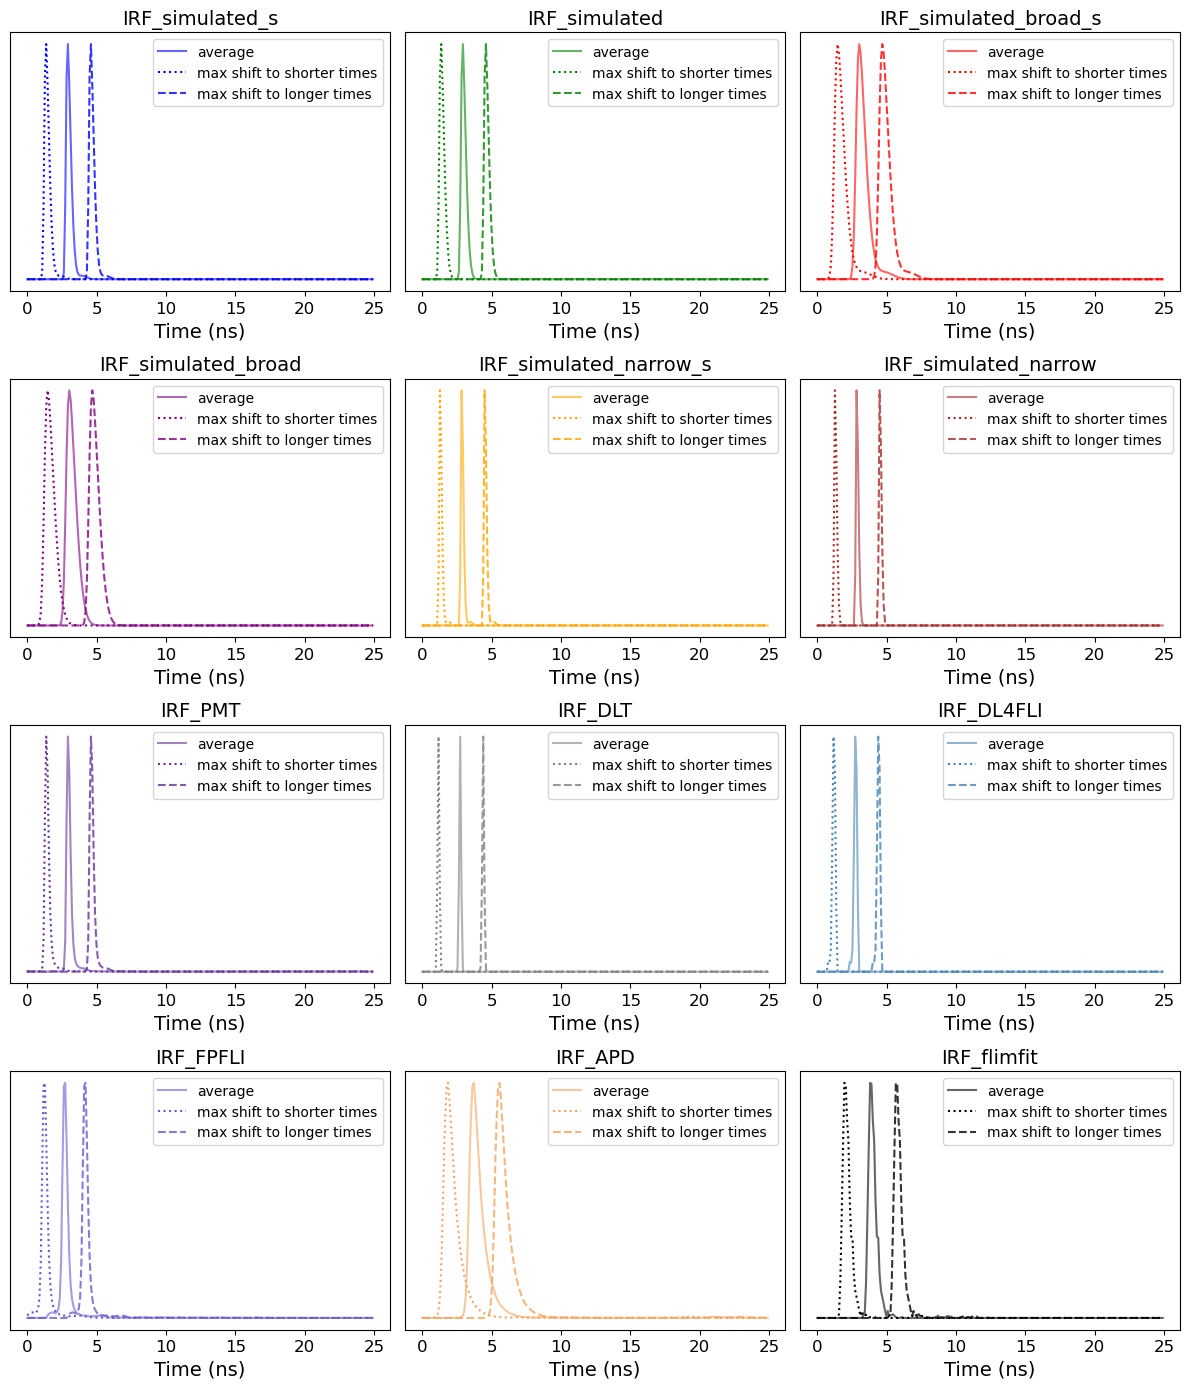

In [13]:
# List of unique colours for each plot
colours = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'rebeccapurple', 'grey', 
           'steelblue', 'slateblue', 'sandybrown', 'black']

# Create a figure with 3 columns and 4 rows of subplots
fig, axes = plt.subplots(4, 3, figsize=(12, 14))  # 4 rows, 3 columns

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Loop over each IRF and plot it in the corresponding subplot
for i, irf_id in enumerate(dict_irfs['irf_id']):
    irf_select, lj = select_irf(irf_id, dict_irfs)
    # Assign a unique colour from the colours list
    plot_lj_effect(axes[i], irf_select, lj, plot_title=irf_id, colour=colours[i])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

## Save data 

In [14]:
hf = h5py.File(os.path.join("data", 'irf_library.h5'), 'w')
dict_group = hf.create_group('dict_irfs')
for k, v in dict_irfs.items():
    dict_group[k] = v
hf.close()